In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
from scipy.interpolate import NearestNDInterpolator
from scipy.optimize import curve_fit 
import scipy.integrate as integrate
import scipy.special as special
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
import emcee

from initial_guess_ellipse import *






from collections import OrderedDict


In [2]:
tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
absorp_tab = Table.read('/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/3d_cmz_pIII_tab2.csv')
starcount_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/starcounts_tab.tex")

xray_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/xray_methods.tex")
nogueras_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/nogueras_measures.tex")


cat_index = tab['leaf_id']
cloud_name = tab['cloud_name']
corr_coeff = tab['corr_coeff']
flux_diff = tab['flux_diff']
fdiff_stdv = tab['flux_diff_stdv']
flux_ratio = tab['flux_ratio']
fratio_stdv = tab['flux_ratio_stdv']
absorp_value = tab['absorp_value']
absorp_sigma = tab['absorp_sigma']
starcount_ratio = starcount_tab['counts_ratio_from_avg']
starcount_ratio_stdv = starcount_tab['counts_ratio_stdv']
nogueras_value = nogueras_tab['LOS_dist_pc']
nogueras_sigma = nogueras_tab['sigma_pc']


            
            

In [3]:
xray_tab

cloud_index,cloud_name,xray_NEAR_los_dist_pc,xray_FAR_los_dist_pc,uncertainty,reference,comment
int64,str12,float64,float64,float64,str11,int64
13,G0.068-0.076,10.0,-30.0,nan,Clavel+2013,--
14,G0.105-0.08,20.0,-30.0,nan,Clavel+2013,--


In [4]:
def z_norming(i, min_value, max_value):
    z_i = 2. * ((i - min_value) / (max_value - min_value)) - 1.
    return z_i

def stdv_z_norming(i, min_value, max_value):
    z_i =  ((i - min_value) / (max_value - min_value)) 
    return z_i

# normalize the data value between -1 and 1 for the 
# flux difference list 
# but need to center it on -108
fdiff_cn = z_norming(-108, -150, 150)

fdiff_stdv_centered = fdiff_stdv 

# flux ratio is centered on 0.5
fratio_cn = z_norming(0.5, 0., 1.)
fratio_stdv_centered = (fratio_stdv)

# Absorption centered on 1.
#absorp_cn = z_norming(1., np.nanmin(absorp_value), 3.5)
absorp_cn = z_norming(1., 0, 2)


# Star Count ratio centered on 1, min 0 and max 2
countratio_cn = z_norming(1., 0, 2)


flux_ratio_normed = []
flux_diff_normed = []
fdiff_stdv_normed = []
fratio_stdv_normed = []
absorp_normed = []
absorp_stdv_normed = []
starcounts_normed = []
starcounts_stdv_normed = []
counts_ratio_stdv_calc = []

for i in range(len(cat_index)):
    
    ###FDIFF NORMING 
    z_fdiff_i = z_norming(flux_diff[i], -150, 150)
    flux_diff_normed.append(z_fdiff_i-fdiff_cn) 
    
    z_fdiff_stdv_i = stdv_z_norming(fdiff_stdv_centered[i],-150,150)
    fdiff_stdv_normed.append(z_fdiff_stdv_i)
    
    ###FRATIO NORMING 
    z_i = z_norming(flux_ratio[i], 0, 1)
    flux_ratio_normed.append(-(z_i-fratio_cn)) 
    
    #z_fratio_stdv_i = z_norming(fratio_stdv_centered[i], np.nanmin(flux_ratio), np.nanmax(flux_ratio))
    z_fratio_stdv_i = stdv_z_norming(fratio_stdv_centered[i], 0, 1)
    fratio_stdv_normed.append(np.abs((z_fratio_stdv_i)))
    
    ###ABSORP NORMING 
    if np.isnan(absorp_value[i]) == False:
        if absorp_value[i]<34:
            if cat_index[i] == '25' or cat_index[i] == '9': #manually exclude SgrB2 and 20 kms Cloud.
                absorp_normed.append(np.nan)
                absorp_stdv_normed.append(np.nan)
            else: 
                #z_i_absorp = z_norming(absorp_value[i], np.nanmin(absorp_value), 3.5)
                z_i_absorp = z_norming(absorp_value[i], 0,2)
                absorp_normed.append(float(-(z_i_absorp-absorp_cn)))

                z_i_absorp_stdv = stdv_z_norming(absorp_sigma[i],0,1)
                absorp_stdv_normed.append(float(z_i_absorp_stdv))
            
        if absorp_value[i]>34: #ID 8b has an extremely large absoprtion frac. Should be ignored.
            absorp_normed.append(np.nan)
            absorp_stdv_normed.append(np.nan)

    if np.isnan(absorp_value[i]) == True:
        absorp_normed.append(np.nan)
        absorp_stdv_normed.append(np.nan)
        
    ###STARCOUNTS NORMING
    z_countratio_i = z_norming(starcount_ratio[i], 0, 2)
    starcounts_normed.append(-(z_countratio_i-countratio_cn) )
    
    #z_countratio_stdv_i =  stdv_z_norming(starcount_stdv_filter[i], np.nanmin(starcount_stdv_filter), np.nanmax(starcount_stdv_filter))
    
    z_countratio_stdv_i =  stdv_z_norming(starcount_ratio_stdv[i], 0,2)
    counts_ratio_stdv_calc.append(z_countratio_stdv_i)
    
starcounts_stdv_normed = np.full(len(counts_ratio_stdv_calc), 3*np.nanmax(counts_ratio_stdv_calc))
#starcounts_stdv_normed = 3* counts_ratio_stdv_calc
#fratio_stdv_normed = np.full(len(fratio_stdv_normed),np.nanmean(fratio_stdv_normed)) #flux ratio is also fairly susceptible to uncertainty in the central region





In [24]:
countratio_cn

0.0

In [5]:
#This dist used for flux ratio, flux diff, and starcount methods
def gauss_dist(x, mu, sigma):
    sigma=abs(sigma)
    #factor = 1./( sigma * np.sqrt(2.*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
    return    exp 



def corr_coeff_gauss_dist(x, mu):
    if np.isnan(mu)==True:
        return x*np.nan

    if (mu < 0) or (mu > 0.3):
        sigma = np.nanstd(corr_coeff)
    if (mu < 0.3) & (mu >= 0):
        sigma = np.nanstd(3.*corr_coeff)
    
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return   exp 



def absorp_gauss_dist(x, mu, sigma):
    #sigma = 0.3*mu #sigma is 30% of the peak value
    #sigma = np.nanstd(absorp_normed, where=np.array(absorp_value)<3.5)
    #factor = 1./( sigma * np.sqrt(2*np.pi))
    exp = np.exp(- (x - mu)**2 / (2.* (sigma**2 )))
        
    return     exp 



#xray methods use step function
def hat(x,fdist, ndist):
    y=np.zeros(np.shape(x))
    
    # need to normalize so area under the curve is unity
    width = abs(fdist - ndist)
    h = 1./width
    y[(x<ndist) & (x>fdist)]+=h
    y[(x>=ndist)|(x<=fdist)]=0
    
     
    return y



#For creating a posterior gaussian after the fittings
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))



In [6]:
### XRAY METHODS ###
# Xray methods give results in pc in front/behind
# Use the initial guess of an ellipse to convert to (-1,1) N/F scale?
# top-down y radius 

#############################
# define initial guess ring
#############################

a_rings = 0.09 # x axis of the rings in kpc
b_rings = 0.055 # y axis of the rings in kpc
z_rings = 0.0125 # height of the ring above/below plane in kpc
v_rings = 130.0 # tangential velocity at initial point
theta_rings = np.radians(25) # inclination of the rings
dphi = np.radians(1)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
initial_rings = Ring(phi,a_rings,b_rings,z_rings,v_rings,theta_rings,xyzsun,vxyzsun)


# convert initial ellipse y limits to (-1,1)
ring_F_y, ring_N_y = np.nanmin(initial_rings.y), np.nanmax(initial_rings.y)
ring_F_y, ring_N_y =-.100,.100


In [11]:
x = np.arange(-20,20, 0.01)
    
def weights(self_dict, key):
    
    
    num_keys = len(self_dict.items())-1
    w_list = []
    
    for i in self_dict.items():
        if i[0] == 'corr_coeff': 
            ww_corr = 2.
            w_list.append(ww_corr)
        if i[0] == 'absorp': 
            ww_absorp = 2.
            w_list.append(ww_absorp)
        if i[0] == 'fratio': 
            ww_fratio = 1.
            w_list.append(ww_fratio)
        if i[0] == 'fdiff': 
            ww_fdiff = 1.
            w_list.append(ww_fdiff)
        if i[0] == 'starcount': 
            ww_starcounts = 1.
            w_list.append(ww_starcounts)
        if i[0] == 'nogueras': 
            ww_nogueras = 1.
            w_list.append(ww_nogueras)
        if i[0] == 'xray':  
            ww_xray = 4.
            w_list.append(ww_xray)
        
    total_w = np.sum(w_list)
    
    if key == 'corr_coeff':  return ww_corr        /total_w
    if key == 'absorp':      return ww_absorp      /total_w
    if key == 'fratio':      return ww_fratio      /total_w
    if key == 'fdiff':       return ww_fdiff       /total_w
    if key == 'starcount':   return ww_starcounts  /total_w
    if key == 'nogueras':    return ww_nogueras    /total_w
    if key == 'xray':        return ww_xray        /total_w
    if key == 'posterior':   return 1.
    
    

class ppdf:
        
    def __init__(self, cloud_id):

        x = np.arange(-20,20, 0.01)

        cat_id = np.where(cat_index == cloud_id)[0][0]

        if np.isnan(corr_coeff[cat_id])==False:
            r_dist = corr_coeff_gauss_dist(x, corr_coeff[cat_id]) 
            r_norm = integrate.quad(corr_coeff_gauss_dist, -np.inf, np.inf, args=(corr_coeff[cat_id]))[0]
            r_dist      /=  r_norm 
            self.corr_coeff = r_dist 

        if np.isnan(absorp_normed[cat_id])==False:
            #absorp_dist = absorp_gauss_dist(x, absorp_normed[cat_id])
            absorp_dist = gauss_dist(x, absorp_normed[cat_id],3*absorp_stdv_normed[cat_id])
            absorp_norm = integrate.quad(gauss_dist, -np.inf, np.inf, args=(absorp_normed[cat_id], 3*absorp_stdv_normed[cat_id]))[0]
            #absorp_norm = integrate.quad(absorp_gauss_dist, -np.inf, np.inf, args=(absorp_normed[cat_id]))[0]
            absorp_dist /=  absorp_norm
            self.absorp = absorp_dist 

        if np.isnan(flux_ratio_normed[cat_id])==False:
            fratio_dist = gauss_dist(x, flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id])
            fratio_norm = integrate.quad(gauss_dist, -np.inf, np.inf, args=(flux_ratio_normed[cat_id],fratio_stdv_normed[cat_id]))[0]
            fratio_dist /=  fratio_norm 
            self.fratio = fratio_dist

        if np.isnan(flux_diff_normed[cat_id])==False:
            fdiff_dist = gauss_dist(x, flux_diff_normed[cat_id],fdiff_stdv_normed[cat_id] )    
            fdiff_norm = integrate.quad(gauss_dist, -np.inf,np.inf, args=(flux_diff_normed[cat_id],fdiff_stdv_normed[cat_id]))[0]
            fdiff_dist  /=  fdiff_norm
            self.fdiff = fdiff_dist

        if np.isnan(starcounts_normed[cat_id])==False:
            starcount_dist = gauss_dist(x, starcounts_normed[cat_id],starcounts_stdv_normed[cat_id] )    
            starcount_norm = integrate.quad(gauss_dist, -np.inf,np.inf, args=(starcounts_normed[cat_id],starcounts_stdv_normed[cat_id]))[0]
            starcount_dist  /=  starcount_norm
            self.starcount = starcount_dist
            
        #xray method for relevant clouds (modeled by tophat)
        if (cloud_id =='13') | (cloud_id =='14') :
            cloud_n = (xray_tab['xray_NEAR_los_dist_pc'][np.where(xray_tab['cloud_index']==int(cloud_id))][0])/1e3
            cloud_f = (xray_tab['xray_FAR_los_dist_pc'][np.where(xray_tab['cloud_index']==int(cloud_id))][0])/1e3
            print('xray', cloud_n, cloud_f)
            xray_hat_n, xray_hat_f = z_norming(cloud_n, ring_F_y, ring_N_y), z_norming(cloud_f, ring_F_y, ring_N_y)
            self.xray = hat(x,xray_hat_f, xray_hat_n)

        #nogueras LOS measures for 20 and 50 kms Clouds
        if (cloud_id =='9') | (cloud_id =='10') :
            nog_dist_kpc = (nogueras_value[np.where(nogueras_tab['cloud_index']==int(cloud_id))][0])/1e3
            nog_sig_kpc = (nogueras_sigma[np.where(nogueras_tab['cloud_index']==int(cloud_id))][0])/1e3
            nog_dist_normed = z_norming(nog_dist_kpc, ring_F_y, ring_N_y)
            nog_sig_normed  = stdv_z_norming(nog_sig_kpc, ring_F_y, ring_N_y)
            nog_dist = gauss_dist(x, nog_dist_normed,nog_sig_normed)  
            nog_norm = integrate.quad(gauss_dist, -np.inf,np.inf, args=(nog_dist_normed, nog_sig_normed))[0]
            nog_dist /= nog_norm
            self.nogueras = nog_dist


        ### Calculate the posterior PDF
        
        total_pdf = np.empty(np.shape(x))
        total_pdf[:] = 1.
        
        self_dict = vars(self)
        
        uniform_pdf = np.ones(np.shape(x))
        
        ### Assign weights to the distributions
        ### Gaussians are best weighted by the means 
        ### other PDF shapes may be better weighted by amplitude
        for i in self_dict.items():
            #total_pdf *= i[1]
        
            
            if i[0]=='corr_coeff'  :     
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])
            if i[0]=='absorp'      :     
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])
            if i[0]=='fratio'      :     
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])
            if i[0]=='fdiff'       :     
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])
            if i[0]=='starcount'   :     
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])
            if i[0]=='nogueras'        :  
                w = weights(self_dict,i[0])
                i_weighted = (i[1]*(1+w) + uniform_pdf*(w) )/ np.sum(i[1])     
            if i[0]=='xray'        :  
                w = weights(self_dict,i[0])
                i_weighted = i[1]*(1+w) / np.sum(i[1])
       
            
                
            total_pdf  *= i_weighted
            total_norm  = integrate.trapezoid(total_pdf, x)
            total_pdf  /= total_norm
            #total_pdf/=total_pdf.max()
        
        self.posterior = total_pdf
        
        if cloud_id == '16a': 
            self.posterior = np.empty(np.size(total_pdf))
            self.posterior[:] = np.nan 
        

                
        

def plotting_color_label(key):
    if key == 'corr_coeff': return 'blue'
    if key == 'absorp': return 'red'
    if key == 'fratio': return 'green'
    if key == 'fdiff': return 'orange'
    if key == 'starcount': return 'gold'
    if key == 'xray': return 'indigo'
    if key == 'nogueras': return 'cyan'
    if key == 'posterior': return 'gray'

def plotting_linestyles(key):
    if key == 'corr_coeff': return '--'
    if key == 'absorp': return '-'
    if key == 'fratio': return '-.'
    if key == 'fdiff': return '--'
    if key == 'starcount': return '--'
    if key == 'xray': return '-'
    if key == 'nogueras': return '--'
    if key == 'posterior': return '--'
    


In [12]:
##############################################
#USE MCMC TO FIND A 1D PEAK IN THE POSTERIOR?
##############################################
# lnprob_gaussian func from: https://gist.github.com/banados/2254240
# mcmc func/routine based on https://stackoverflow.com/questions/76476366/does-anyone-see-the-mistake-problem-with-my-code-mcmc-using-emcee

def lnprob_gaussian(p, vec):
    diff = vec-p[0]
    N = len(vec)
    return -0.5 * N * np.log(2 * np.pi) - N * np.log(p[1]) - 0.5 \
                                    * np.sum(( (vec - p[0]) / p[1] ) ** 2)
    

#MCMC
def mcmc(x_data, y_data, func, initial_guess = [1,1,1], burning_in = 200, thinner = 50, steps = 5000, walkers = 300, dimension = 3):
#Scipy curve fit

    curve_fit_params, cov= curve_fit(gaussian, x, pdfvec.posterior, 
                                          p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])

    curve_fit_error = np.sqrt(np.diag(cov))

    #MCMC setup

    # Define the log-likelihood function
    def log_likelihood(theta, x, y):
        A, mu, sigma = theta
        y_model = gaussian(x, A, mu, sigma)
        residual = y - y_model
        chi_squared = np.sum(residual**2)
        log_like = -0.5 * chi_squared
        return log_like


    # Define the log-prior function
    def log_prior(theta):
        A, mu, sigma = theta
        # Add any prior constraints here
        # For example, uniform priors for A, mu and sigma between certain ranges
        if 0 < A < 2.*curve_fit_params[0] and 0 < mu < 2.*curve_fit_params[1] and 0 < sigma < 2.*curve_fit_params[2]:
            return 0.0  # log(1) = 0
        return -np.inf  # log(0) = -inf

    # Define the log-posterior function
    def log_posterior(theta, x, y):
        log_prior_val = log_prior(theta)
        if not np.isfinite(log_prior_val):
            return -np.inf  # log(0) = -inf
        log_like_val = log_likelihood(theta, x, y)
        return log_prior_val + log_like_val

    #MCMC

    # Set up the number of walkers and dimensions
    nwalkers = walkers
    ndim = dimension

    # Initialize the walkers with random positions near the maximum likelihood solution
    pos = [0.1 * np.random.randn(ndim) + curve_fit_params for _ in range(nwalkers)]

    # Set up the emcee sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_data, y_data))

    # Run the MCMC sampling
    nsteps = steps  # Number of steps to run the sampler
    sampler.run_mcmc(pos, nsteps, progress = True)

    #tau = sampler.get_autocorr_time()
    #print(tau)

    # Get the chain of samples and flatten it
    samples = sampler.get_chain(discard=burning_in, thin = thinner, flat=True)

    # Get the best-fit parameters (maximum a posteriori or MAP estimate)
    mcmc_fit_mean = np.mean(samples, axis=0)

    # Get the uncertainties in the parameters (credible intervals)
    mcmc_fit_std = np.std(samples, axis=0)

    
    return samples, mcmc_fit_mean, mcmc_fit_std, curve_fit_params, curve_fit_error


#Run the MCMC and store the output into a new class 

class mcmc_post:
        
    def __init__(self, pre_mcmc_post):
        
        samples, mcmc_fit_mean, mcmc_fit_std, curve_fit_params, curve_fit_error = mcmc(x, pre_mcmc_post, gaussian, initial_guess = [1,1,1], burning_in = 200, thinner = 50, steps = 5000, walkers = 100, dimension = 3)
        A_mcmc, mu_mcmc, sig_mcmc = mcmc_fit_mean
        mcmc_dist = gaussian(x, A_mcmc, mu_mcmc, sig_mcmc)
        total_norm  = integrate.trapezoid(mcmc_dist, x)
        mcmc_dist /= total_norm
        #mcmc_dist/=mcmc_dist.max()
        
        mcmc_post.samples = samples
        mcmc_post.mcmc_fit_mean = mcmc_fit_mean
        mcmc_post.mcmc_fit_std = mcmc_fit_std
        mcmc_post.curve_fit_params = curve_fit_params
        mcmc_post.curve_fit_error = curve_fit_error
        mcmc_post.mcmc_dist = mcmc_dist

In [13]:
def plot_pdf(cloud_id, pdfvar, pdf_mcmc):
    
    pdfvec = vars(pdfvar)
    cat_id = np.where(cat_index == cloud_id)[0][0]


    ###Plot the stuff 
    fig, ax = plt.subplots(1, 1)
    for i in pdfvec.items():
        ax.plot(x, i[1], label = '{}'.format(i[0]), linestyle=plotting_linestyles(i[0]), color=plotting_color_label(i[0]) )

    if cloud_id != '16a':
        ax.plot(x, pdf_mcmc.mcmc_dist, label = 'MCMC posterior', linestyle='-', color='k')

    ax.set_xlabel('Near vs Far Distinction', fontsize= 13, labelpad=30)
    ax.set_ylabel('Relative Probability',fontsize= 13)

    ax.grid(axis='y')
    

    #ax.set_ylim(0,1.1)
    ax.set_xlim(-1,1)
    ax.set_ylim(0, pdf_mcmc.mcmc_dist.max()+1)
    ax.text(.95, .95, 'ID: {}'.format(cat_index[cat_id]), fontsize=13, ha='right', va='top', 
            transform=ax.transAxes)

    ax.text(-0.01, -.08, 'FAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)
    ax.text(0.915, -.08, 'NEAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)

    ax.legend(loc=2)
    
    plt.show()
        
    return

100%|██████████| 5000/5000 [00:25<00:00, 199.46it/s]


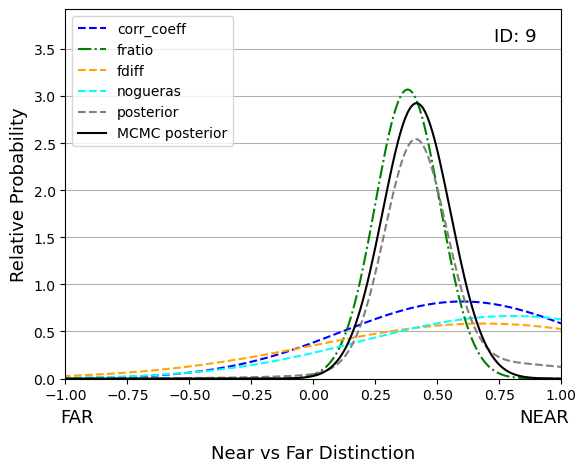

In [15]:
cloudd = '9'
pdfvec=ppdf(cloudd)
mcmc_pdfvec = mcmc_post(pdfvec.posterior)
plot_pdf(cloudd,pdfvec,mcmc_pdfvec)

In [23]:
z_norming(0.875-1, 0,2)

-1.125

In [68]:
print(pdfvec.absorp)
print(pdfvec.fratio)
print(pdfvec.fdiff)
print(max(pdfvec.posterior))

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[1.66969062e-212 2.64258886e-212 4.18147185e-212 ... 2.52774399e-166
 1.68404177e-166 1.12170491e-166]
8.416845237543846


In [69]:
vars(pdfvec)

{'corr_coeff': array([0., 0., 0., ..., 0., 0., 0.], shape=(4000,)),
 'absorp': array([0., 0., 0., ..., 0., 0., 0.], shape=(4000,)),
 'fratio': array([0., 0., 0., ..., 0., 0., 0.], shape=(4000,)),
 'fdiff': array([1.66969062e-212, 2.64258886e-212, 4.18147185e-212, ...,
        2.52774399e-166, 1.68404177e-166, 1.12170491e-166], shape=(4000,)),
 'starcount': array([0., 0., 0., ..., 0., 0., 0.], shape=(4000,)),
 'posterior': array([6.93440525e-05, 6.93440525e-05, 6.93440525e-05, ...,
        6.93440525e-05, 6.93440525e-05, 6.93440525e-05], shape=(4000,))}

# Run routine for entire catalog and create a table with the PPDF posterior parameters & MC posterior parameters

Running MCMC for cloud 1


100%|██████████| 5000/5000 [00:21<00:00, 229.31it/s]


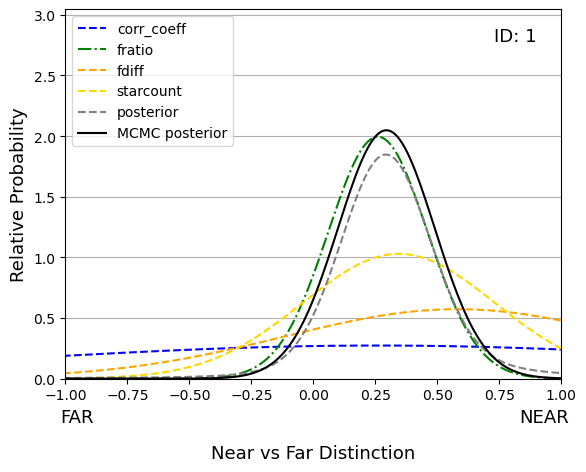

Running MCMC for cloud 2


100%|██████████| 5000/5000 [00:21<00:00, 234.43it/s]


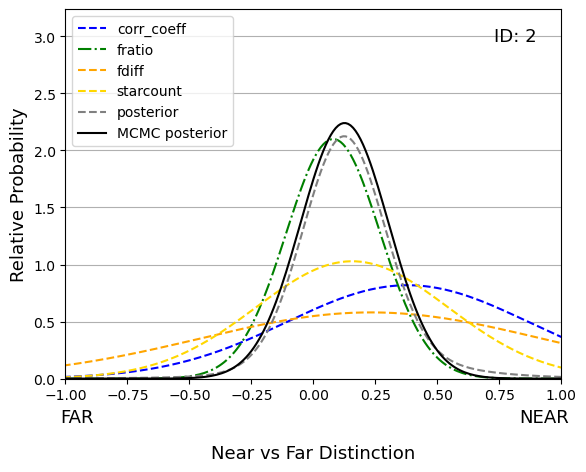

Running MCMC for cloud 3


100%|██████████| 5000/5000 [00:06<00:00, 801.50it/s]


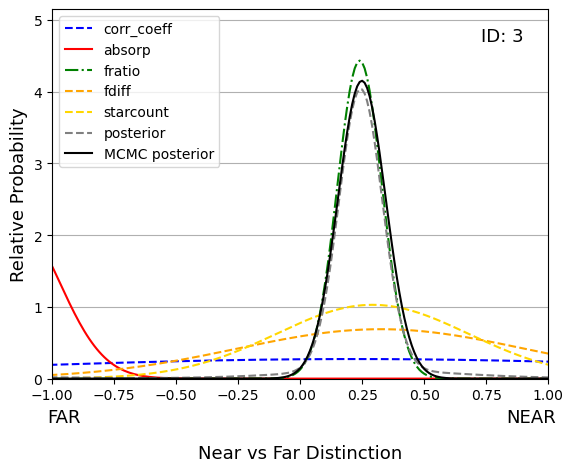

Running MCMC for cloud 4a


100%|██████████| 5000/5000 [00:22<00:00, 222.56it/s]


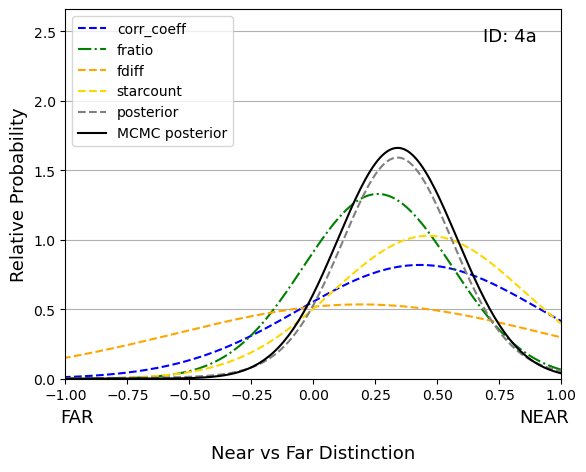

Running MCMC for cloud 4b


100%|██████████| 5000/5000 [00:22<00:00, 222.29it/s]


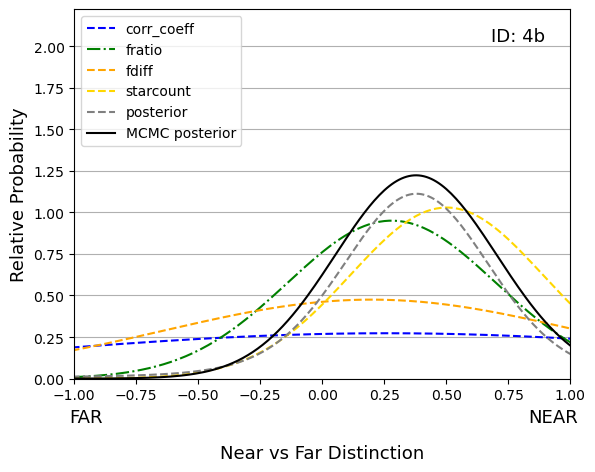

Running MCMC for cloud 5


100%|██████████| 5000/5000 [00:05<00:00, 907.35it/s]


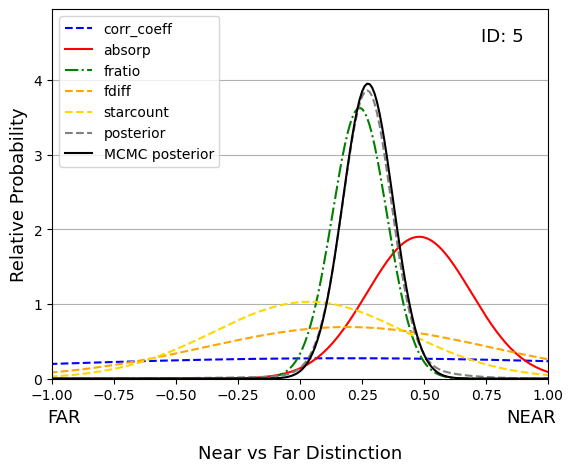

Running MCMC for cloud 6a


100%|██████████| 5000/5000 [00:05<00:00, 931.47it/s]


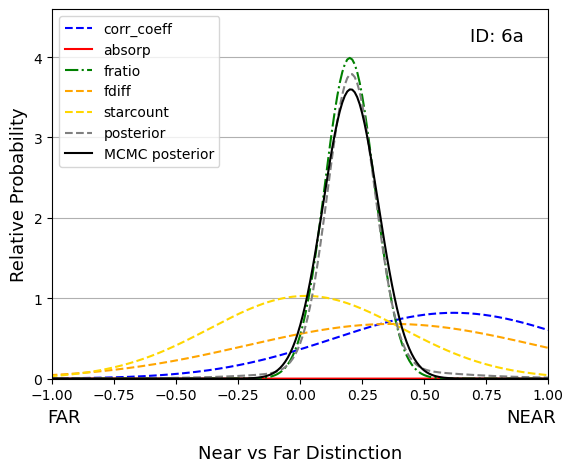

Running MCMC for cloud 6b


100%|██████████| 5000/5000 [00:05<00:00, 893.45it/s]


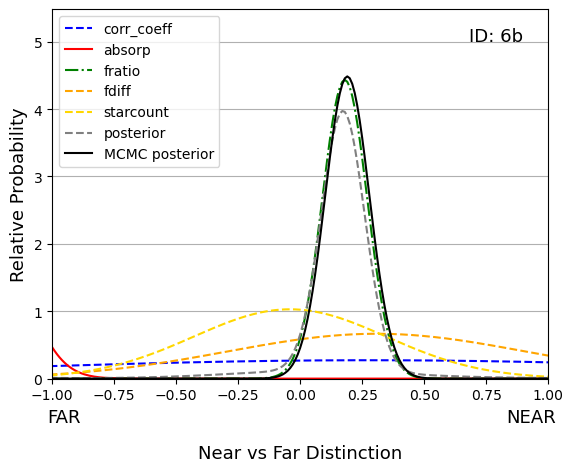

Running MCMC for cloud 7a


100%|██████████| 5000/5000 [00:20<00:00, 246.19it/s]


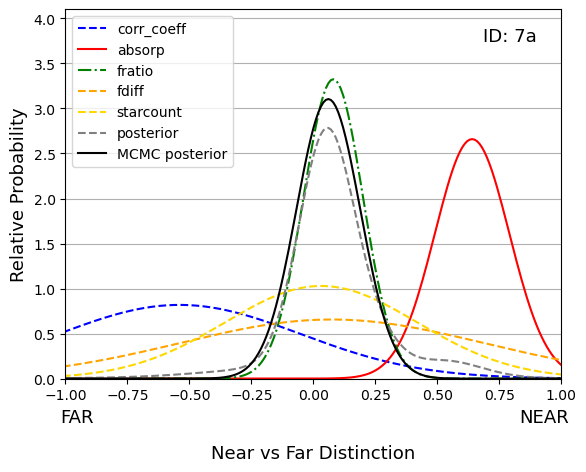

Running MCMC for cloud 7b


100%|██████████| 5000/5000 [00:16<00:00, 303.30it/s]


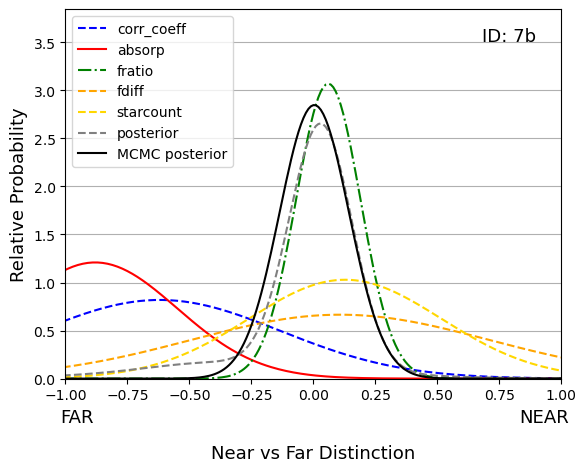

Running MCMC for cloud 8a


100%|██████████| 5000/5000 [00:05<00:00, 939.89it/s]


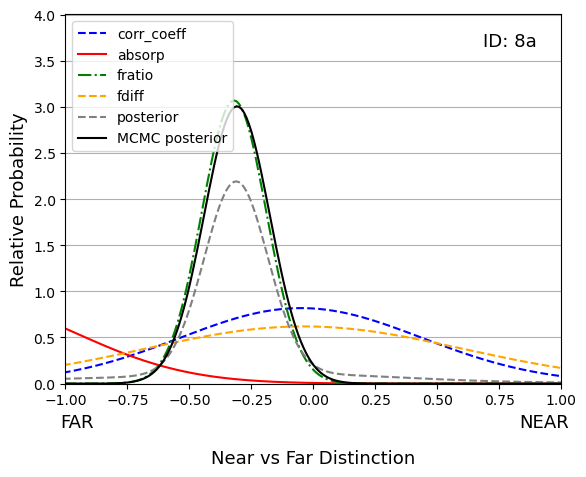

Running MCMC for cloud 8b


100%|██████████| 5000/5000 [00:05<00:00, 882.46it/s]


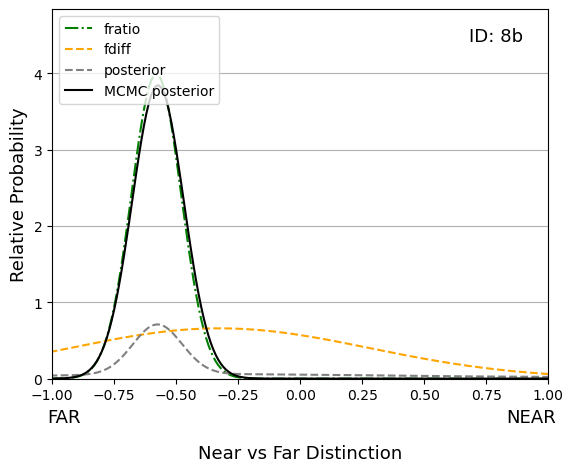

Running MCMC for cloud 8c


100%|██████████| 5000/5000 [00:05<00:00, 922.88it/s]


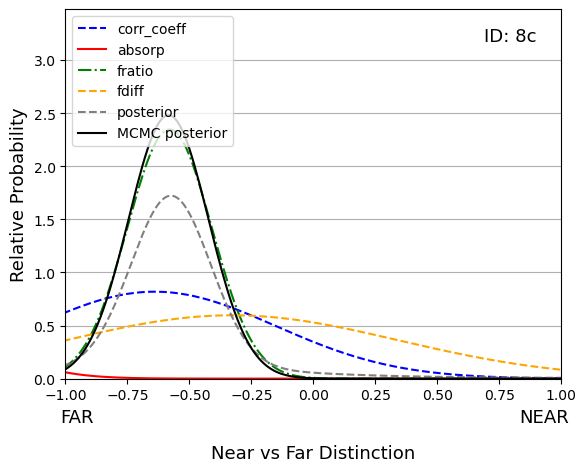

Running MCMC for cloud 9


100%|██████████| 5000/5000 [00:21<00:00, 231.64it/s]


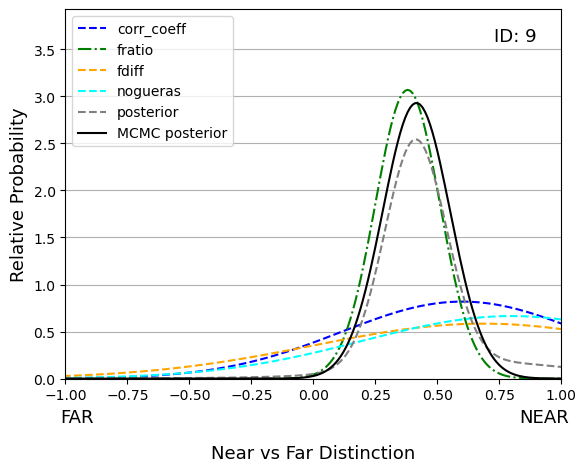

Running MCMC for cloud 10


100%|██████████| 5000/5000 [00:22<00:00, 222.91it/s]


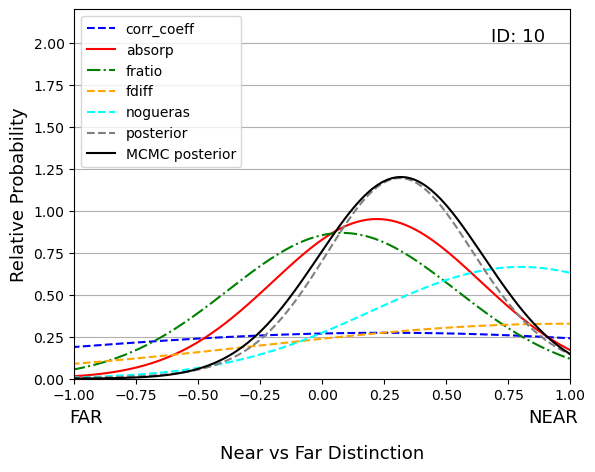

Running MCMC for cloud 11a


100%|██████████| 5000/5000 [00:05<00:00, 952.95it/s]


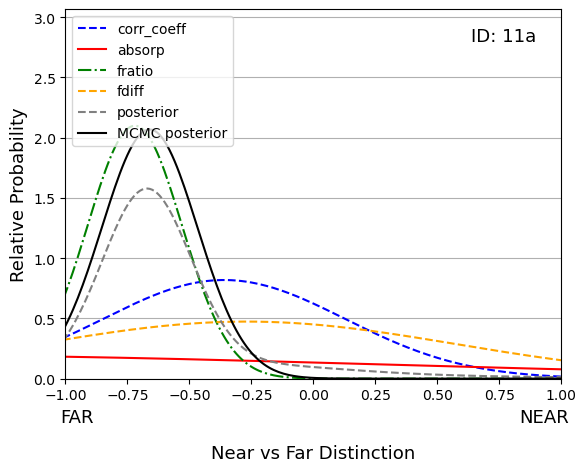

Running MCMC for cloud 11b


100%|██████████| 5000/5000 [00:05<00:00, 968.72it/s]


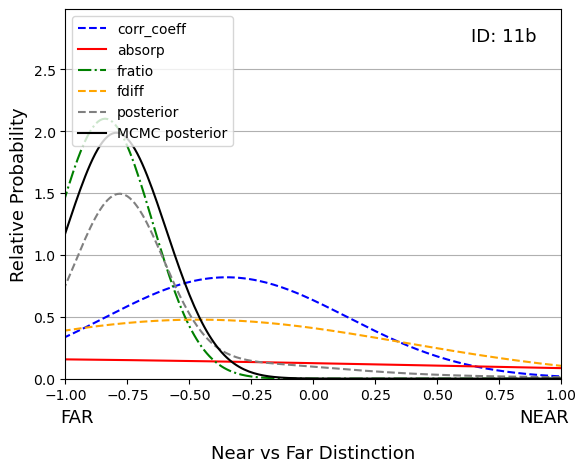

Running MCMC for cloud 11c


100%|██████████| 5000/5000 [00:05<00:00, 963.08it/s]


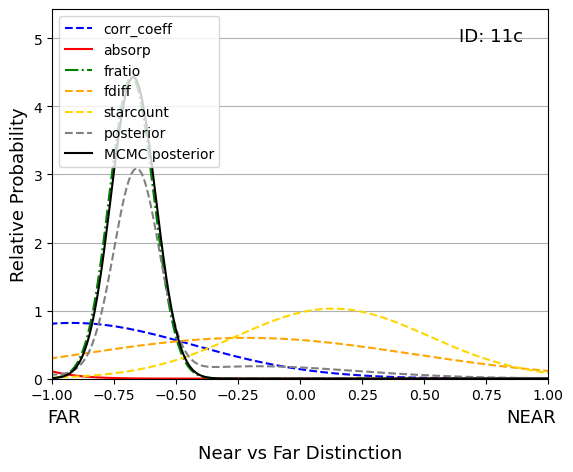

Running MCMC for cloud 12


100%|██████████| 5000/5000 [00:05<00:00, 963.46it/s]


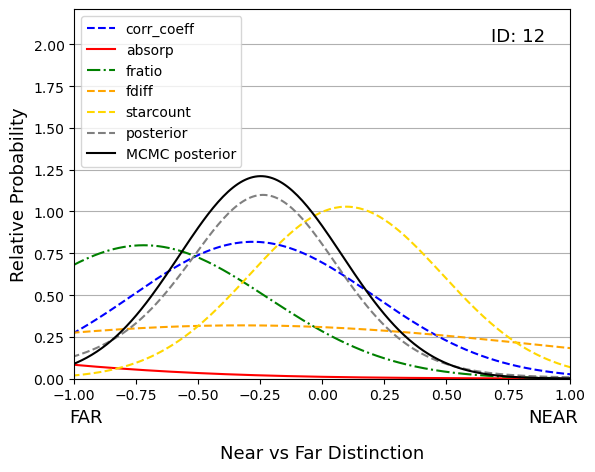

xray 0.01 -0.03
Running MCMC for cloud 13


100%|██████████| 5000/5000 [00:05<00:00, 954.07it/s]


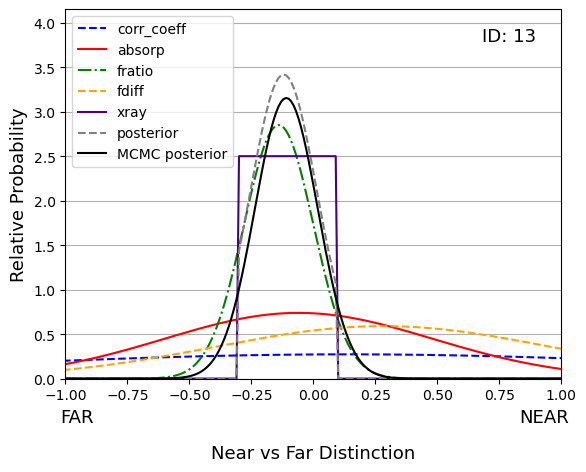

xray 0.02 -0.03
Running MCMC for cloud 14


100%|██████████| 5000/5000 [00:18<00:00, 264.67it/s]


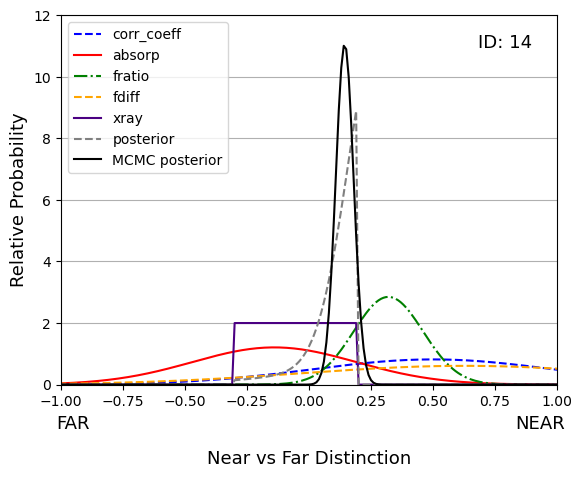

Running MCMC for cloud 15


100%|██████████| 5000/5000 [00:05<00:00, 961.81it/s]


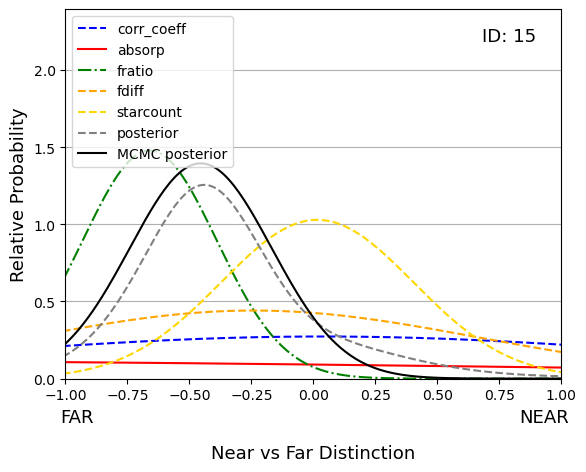

16a is an empty mask, so we fill that with NaNs


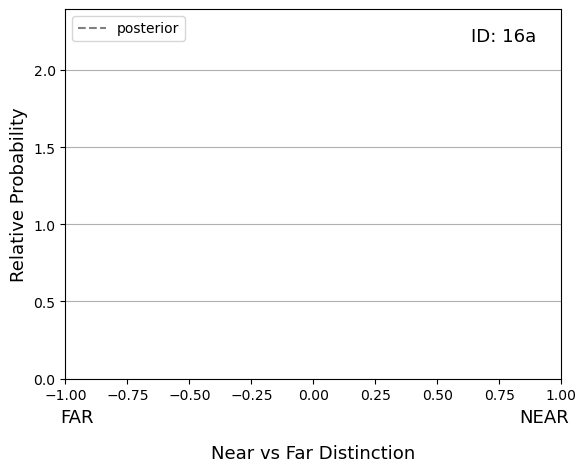

Running MCMC for cloud 16b


100%|██████████| 5000/5000 [00:05<00:00, 935.52it/s]


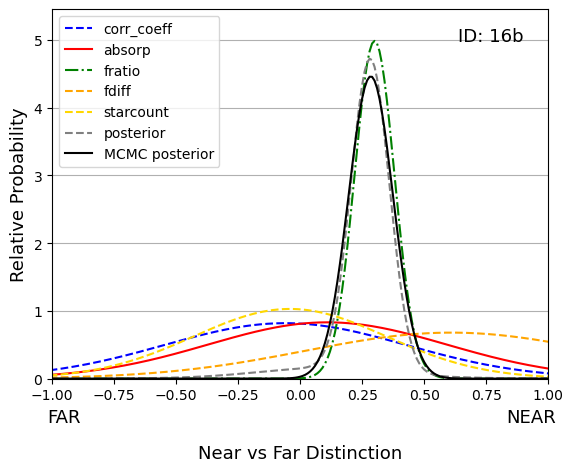

Running MCMC for cloud 17a


100%|██████████| 5000/5000 [00:05<00:00, 936.11it/s]


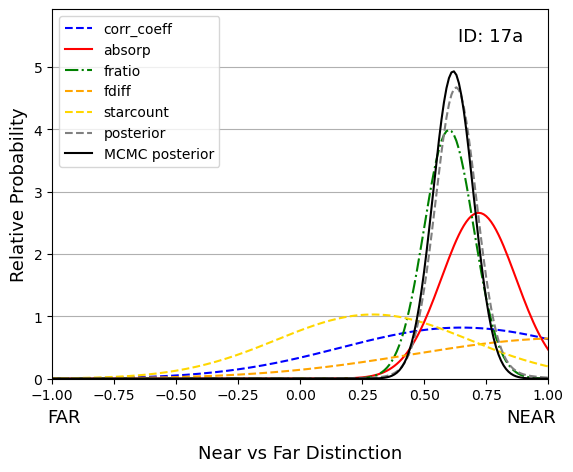

Running MCMC for cloud 17b


100%|██████████| 5000/5000 [00:05<00:00, 926.67it/s]


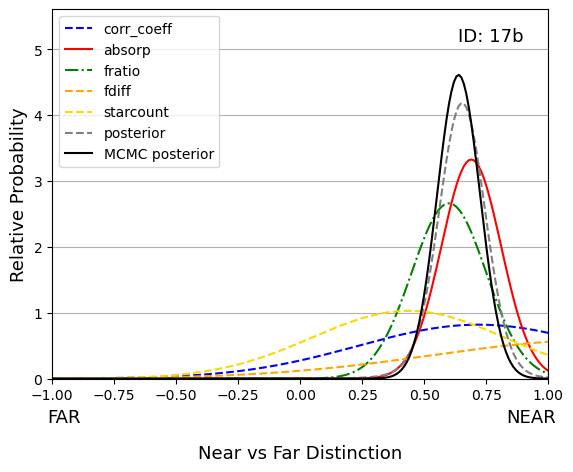

Running MCMC for cloud 17c


100%|██████████| 5000/5000 [00:05<00:00, 934.59it/s]


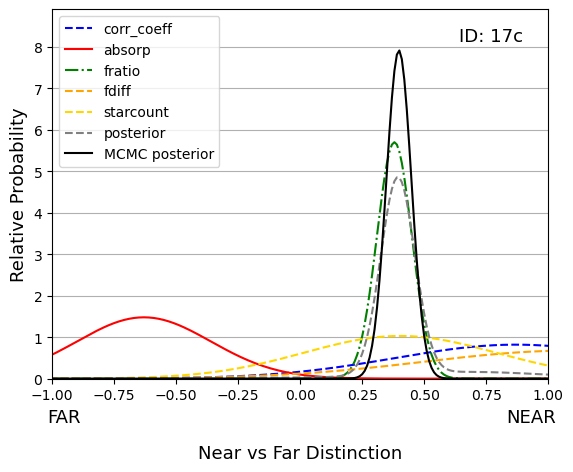

Running MCMC for cloud 18


100%|██████████| 5000/5000 [00:20<00:00, 245.99it/s]


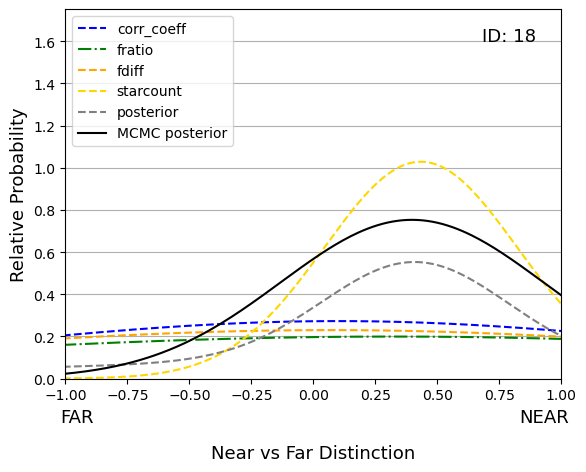

Running MCMC for cloud 19


100%|██████████| 5000/5000 [00:21<00:00, 237.80it/s]


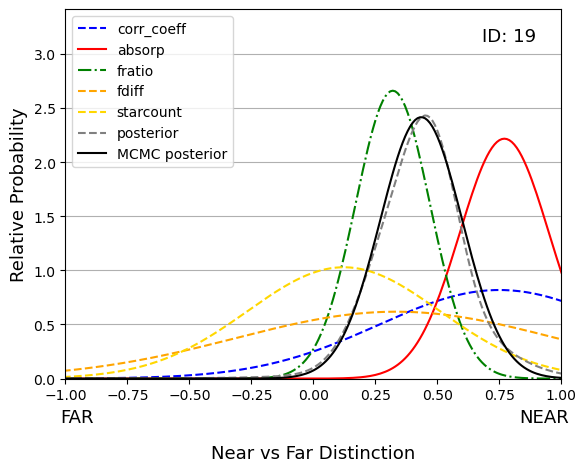

Running MCMC for cloud 20


100%|██████████| 5000/5000 [00:05<00:00, 959.07it/s]


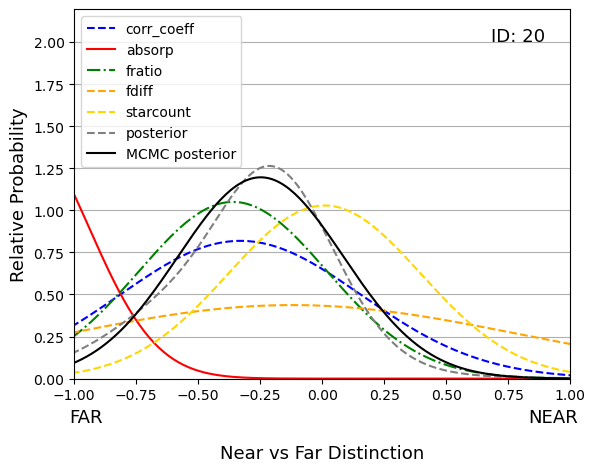

Running MCMC for cloud 21a


100%|██████████| 5000/5000 [00:05<00:00, 937.24it/s]


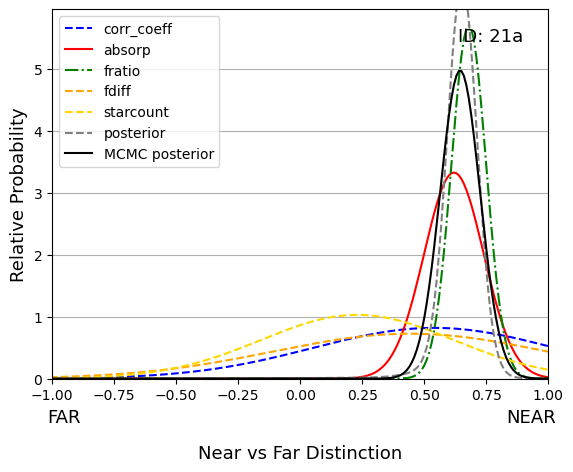

Running MCMC for cloud 21b


100%|██████████| 5000/5000 [00:20<00:00, 242.47it/s]


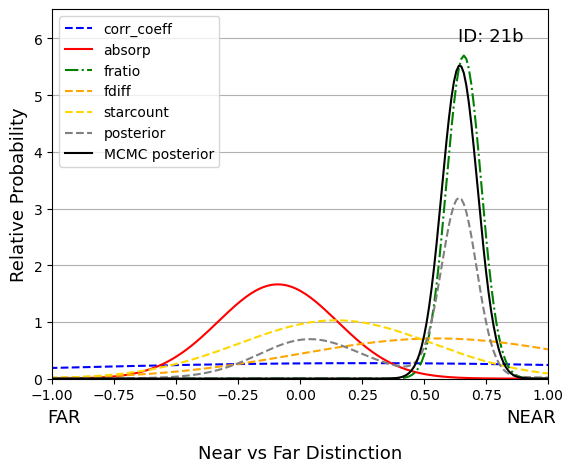

Running MCMC for cloud 22


100%|██████████| 5000/5000 [00:19<00:00, 259.37it/s]


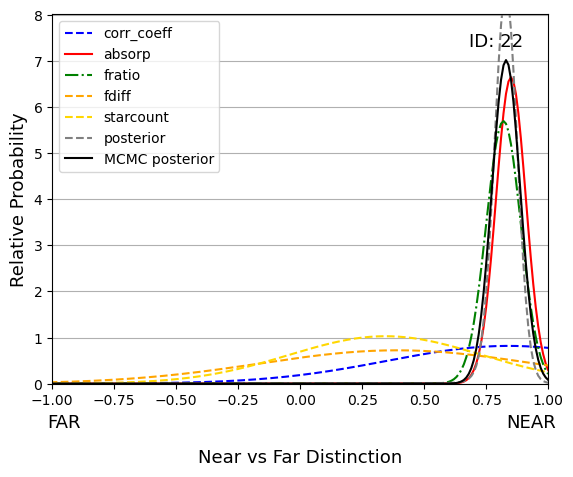

Running MCMC for cloud 23


100%|██████████| 5000/5000 [00:05<00:00, 931.24it/s]


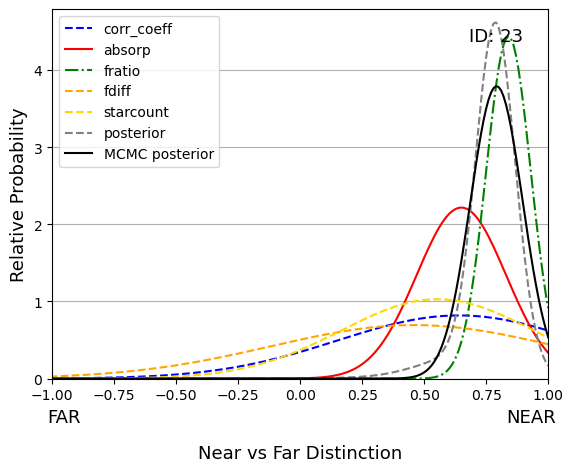

Running MCMC for cloud 24


100%|██████████| 5000/5000 [00:20<00:00, 241.06it/s]


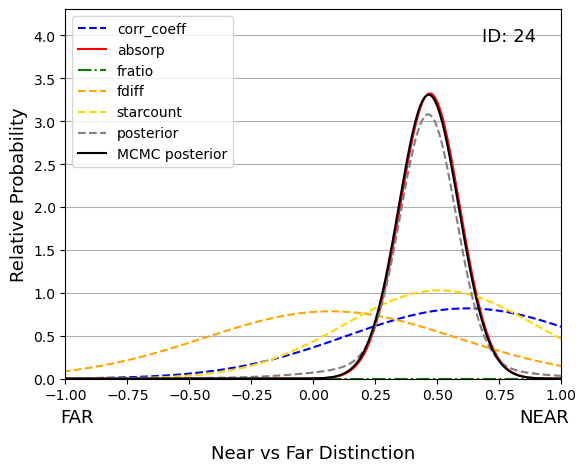

Running MCMC for cloud 25


100%|██████████| 5000/5000 [00:20<00:00, 246.58it/s]


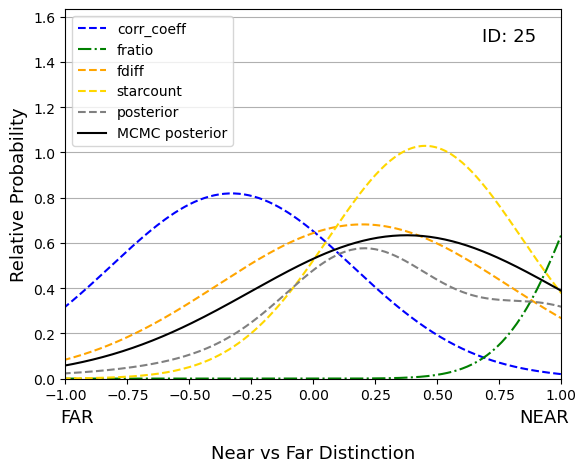

Running MCMC for cloud 26a


100%|██████████| 5000/5000 [00:21<00:00, 227.68it/s]


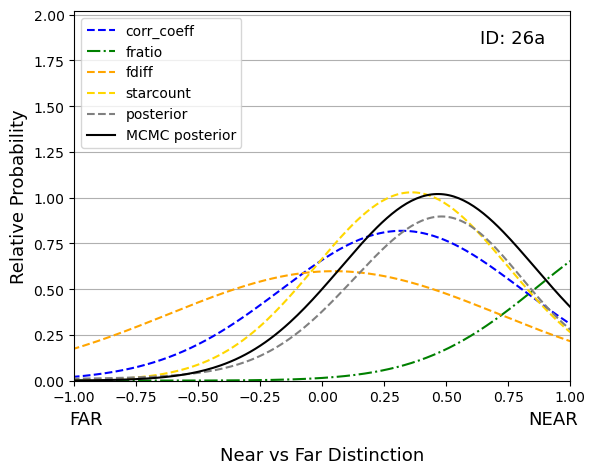

Running MCMC for cloud 26b


100%|██████████| 5000/5000 [00:21<00:00, 233.33it/s]


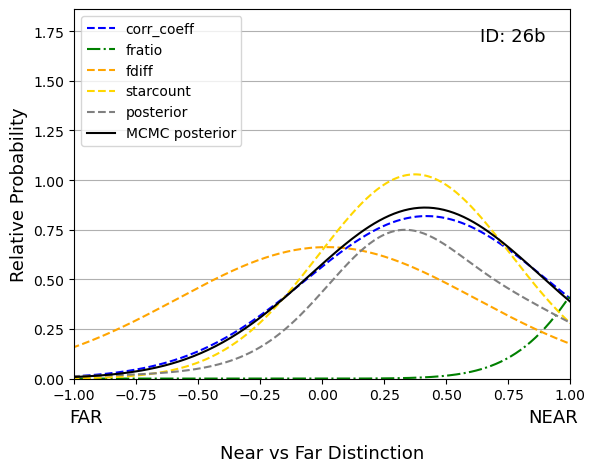

Running MCMC for cloud 27


100%|██████████| 5000/5000 [00:18<00:00, 268.13it/s]


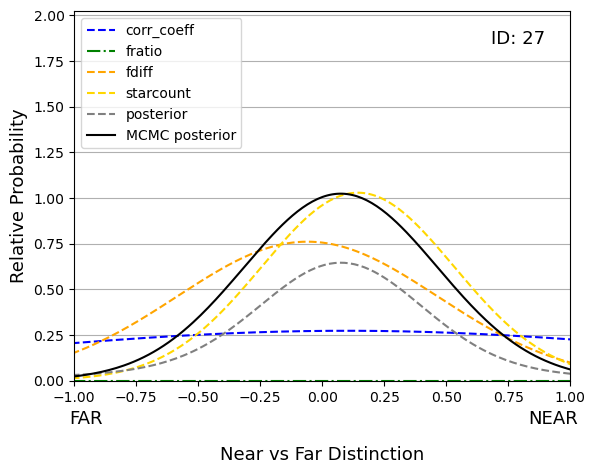

Running MCMC for cloud 28a


100%|██████████| 5000/5000 [00:05<00:00, 960.23it/s]


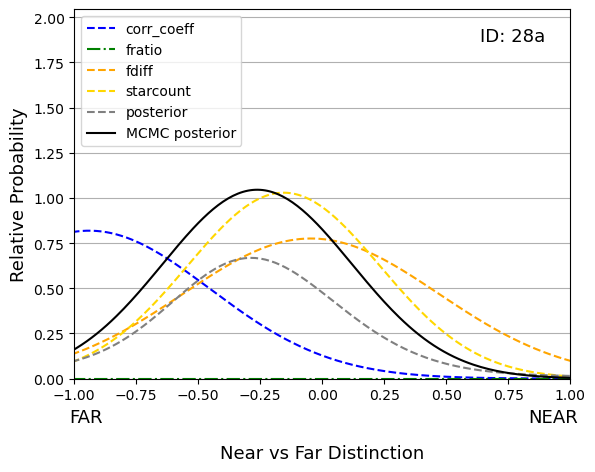

Running MCMC for cloud 28b


100%|██████████| 5000/5000 [00:05<00:00, 959.20it/s]


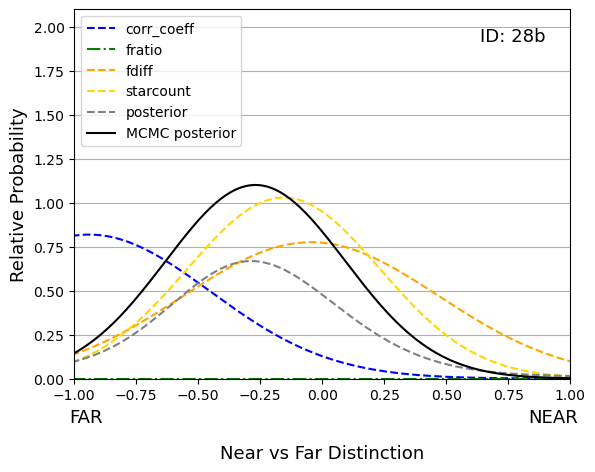

Running MCMC for cloud 28c


100%|██████████| 5000/5000 [00:19<00:00, 262.84it/s]


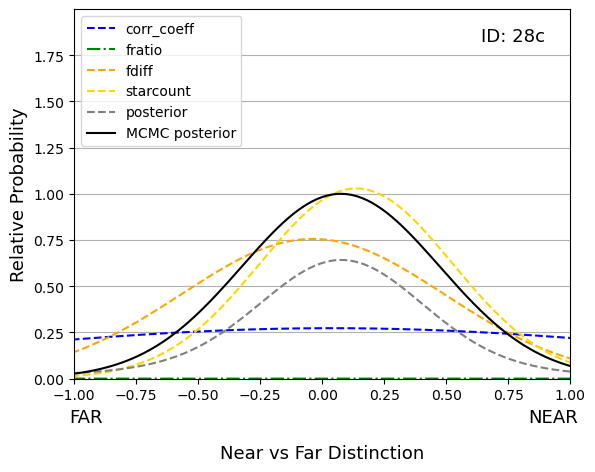

Running MCMC for cloud 29a


100%|██████████| 5000/5000 [03:55<00:00, 21.24it/s]  


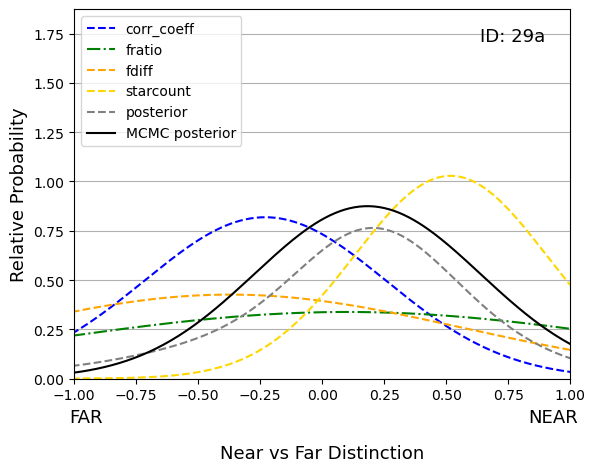

Running MCMC for cloud 29b


100%|██████████| 5000/5000 [00:22<00:00, 221.93it/s]


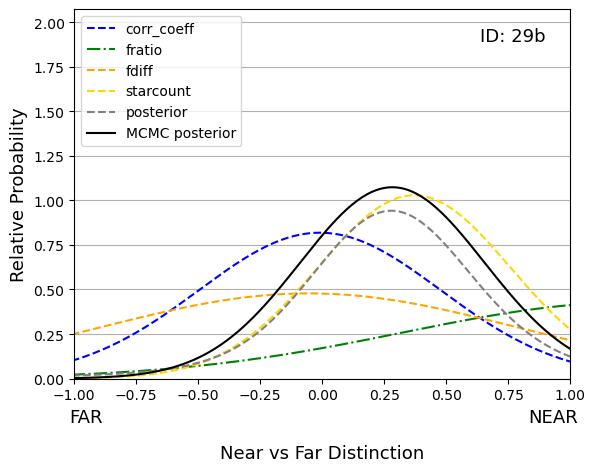

Running MCMC for cloud 30a


100%|██████████| 5000/5000 [00:20<00:00, 238.31it/s]


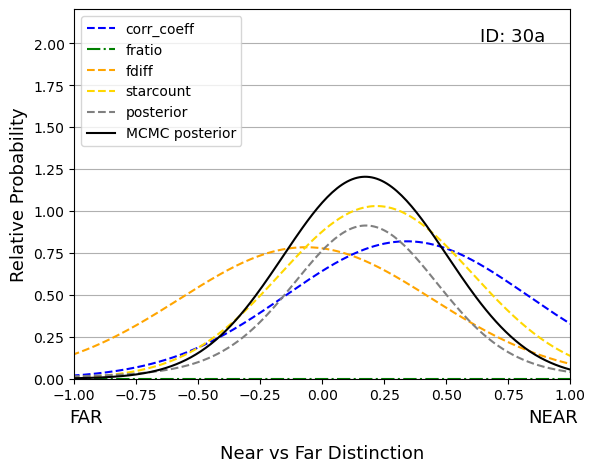

Running MCMC for cloud 30b


100%|██████████| 5000/5000 [00:17<00:00, 279.64it/s]


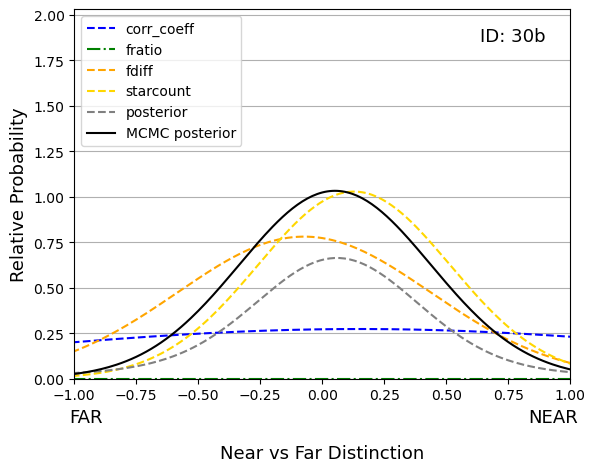

Running MCMC for cloud 31


100%|██████████| 5000/5000 [00:20<00:00, 242.03it/s]


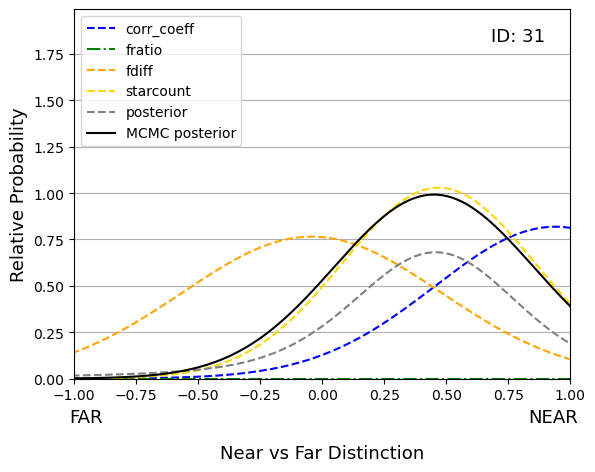

In [17]:
post_tab = Table()
A, mu, sigma, cloudid = [], [], [], []
A_MC, mu_MC, sigma_MC = [], [], []

#for i in ['2','16a', '17b']:

for i in cat_index:
    cat_id = np.where(cat_index == i)[0][0]
    
    #determine the PPDF from the various methods
    pdfvec=ppdf(i)
    
    #run MCMC to get final posterior (mostly to ensure we are able to summarize with a single peak)
    
    if i!='16a':
        print("Running MCMC for cloud {}".format(i))
        mcmc_pdfvec = mcmc_post(pdfvec.posterior)
        A_mcmc, mu_mcmc, sigma_mcmc = mcmc_pdfvec.mcmc_fit_mean
    if i =='16a':
        print("16a is an empty mask, so we fill that with NaNs")
        A_MC.append(np.nan)
        mu_MC.append(np.nan)
        sigma_MC.append(np.nan)
        A_mcmc, mu_mcmc, sigma_mcmc = np.nan, np.nan, np.nan
        
    
    
    #This is to do a curve-fit for the non-MC parameters (i.e. the original PPDF result)
    if (~np.isnan(pdfvec.posterior).any()) & (i != '16a') == True:
        parameters, covariance =curve_fit(gaussian, x, pdfvec.posterior, 
                                          p0 = [1, x[np.where(pdfvec.posterior==np.max(pdfvec.posterior))][0],
                                                np.std(pdfvec.posterior)])
        A.append(parameters[0])
        mu.append(parameters[1])
        sigma.append(parameters[2])
        
        
        A_MC.append(A_mcmc)
        mu_MC.append(mu_mcmc)
        sigma_MC.append(sigma_mcmc)
        
    
        cloudid.append(i)
        
    else:
        A.append(np.nan)
        mu.append(np.nan)
        sigma.append(np.nan)
        cloudid.append(i)
        
        
        
    #PLOT!!!!
    plot_pdf(i, pdfvec, mcmc_pdfvec)
        

post_tab['cloud_id'] = cloudid
post_tab['A_MC'] = A_MC
post_tab['mu_MC'] = mu_MC
post_tab['sigma_MC'] = sigma_MC
#post_tab['A'] = A
#post_tab['mu'] = mu
#post_tab['sigma'] = sigma

    
post_tab.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex", overwrite=True)



In [ ]:
post_tab[25]

cloud_id,A_MC,mu_MC,sigma_MC
str3,float64,float64,float64
17b,8.276557202101296,0.662158473866008,0.03448454961590504


# Paper Figure

In [18]:
def plot_pdf_ax(cloud_id, pdfvar, pdf_mcmc, ax):
    
    pdfvec = vars(pdfvar)
    cat_id = np.where(cat_index == cloud_id)[0][0]

    
    ###Plot the stuff 
    for i in pdfvec.items():
        ax.plot(x, i[1], label = '{}'.format(i[0]), linestyle=plotting_linestyles(i[0]), color=plotting_color_label(i[0]) )

    if cloud_id != '16a':
        ax.plot(x, pdf_mcmc.mcmc_dist, label = 'MCMC posterior', linestyle='-', color='k')

    ax.set_xlabel('Near vs Far Distinction', fontsize= 13, labelpad=30)
    ax.set_ylabel('Relative Probability',fontsize= 13)

    ax.grid(axis='y')
    

    #ax.set_ylim(0,1.1)
    ax.set_xlim(-1,1)
    ax.set_ylim(0, pdf_mcmc.mcmc_dist.max()+1)
    ax.text(.95, .95, 'ID: {}'.format(cat_index[cat_id]), fontsize=13, ha='right', va='top', 
            transform=ax.transAxes)

    ax.text(-0.01, -.08, 'FAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)
    ax.text(0.915, -.08, 'NEAR', fontsize=13, ha='left', va='top', 
            transform=ax.transAxes)

    ax.legend(loc=2)
    

        
    return

  0%|          | 0/5000 [00:00<?, ?it/s]/opt/anaconda3/envs/python3_13/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:21<00:00, 238.06it/s]


xray 0.01 -0.03


100%|██████████| 5000/5000 [00:05<00:00, 951.71it/s]


xray 0.02 -0.03


100%|██████████| 5000/5000 [00:19<00:00, 255.80it/s]


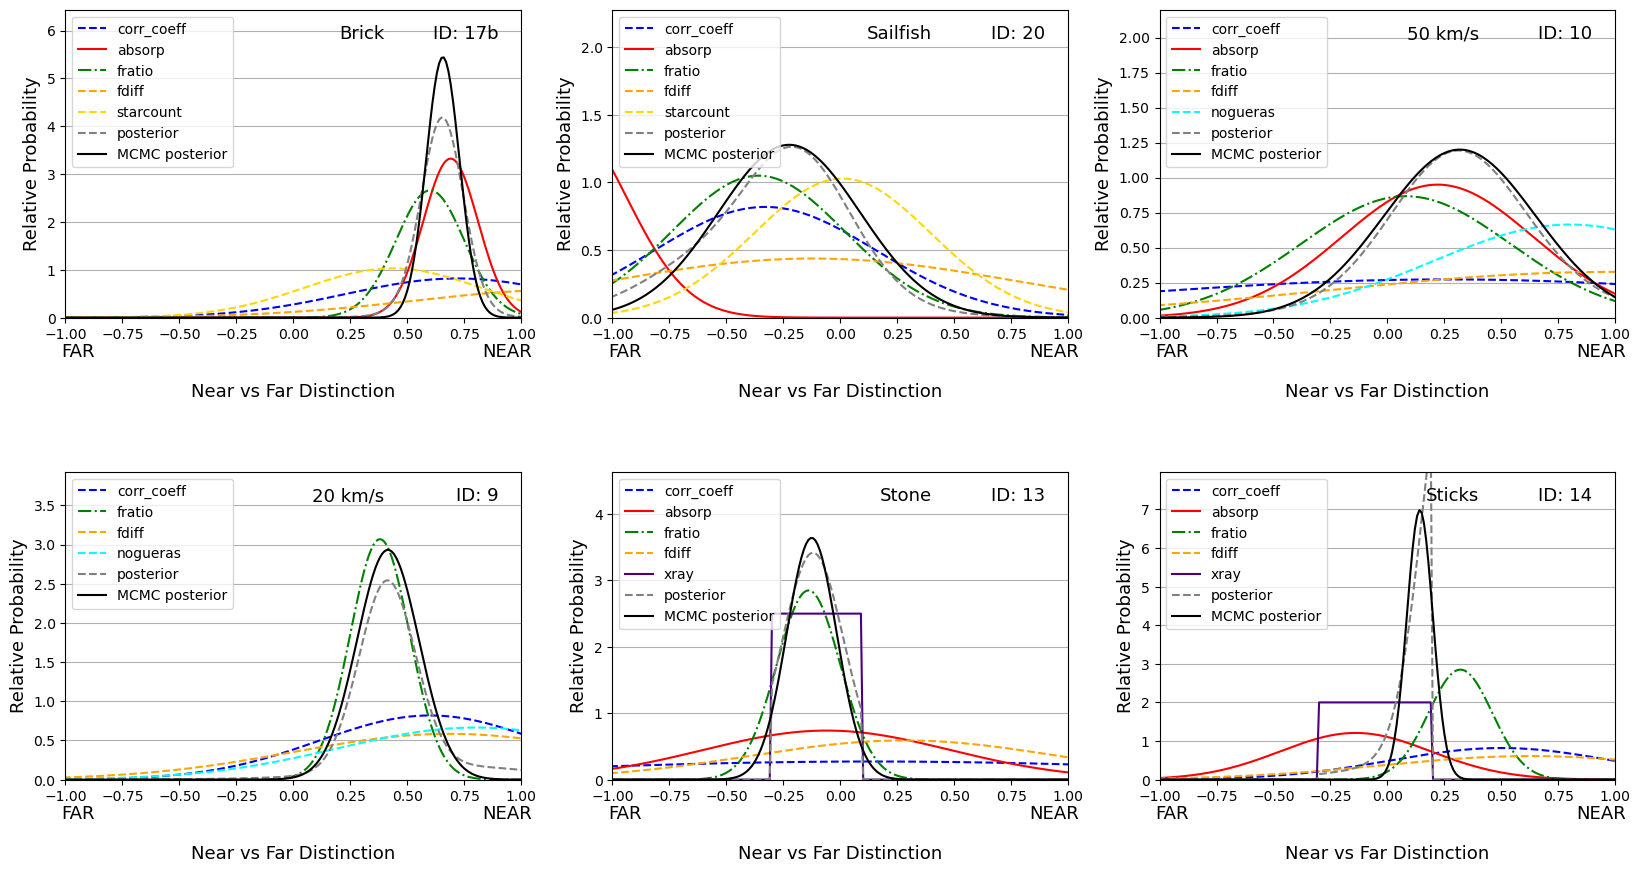

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)
fig.set_facecolor('white')
fig.set_facecolor('white')


cloudd = '17b'
pdfvec=ppdf(cloudd)
mcmc_pdfvec = mcmc_post(pdfvec.posterior)
plot_pdf_ax(cloudd,pdfvec,mcmc_pdfvec,ax[0][0])
ax[0][0].text(.7, .95, 'Brick', fontsize=13, ha='right', va='top', 
            transform=ax[0][0].transAxes)

cloudd = '20'
pdfvec=ppdf(cloudd)
mcmc_pdfvec = mcmc_post(pdfvec.posterior)
plot_pdf_ax(cloudd,pdfvec,mcmc_pdfvec,ax[0][1])
ax[0][1].text(.7, .95, 'Sailfish', fontsize=13, ha='right', va='top', 
            transform=ax[0][1].transAxes)

cloudd = '10'
pdfvec=ppdf(cloudd)
mcmc_pdfvec = mcmc_post(pdfvec.posterior)
plot_pdf_ax(cloudd,pdfvec,mcmc_pdfvec,ax[0][2])
ax[0][2].text(.7, .95, '50 km/s', fontsize=13, ha='right', va='top', 
            transform=ax[0][2].transAxes)

cloudd = '9'
pdfvec=ppdf(cloudd)
mcmc_pdfvec = mcmc_post(pdfvec.posterior)
plot_pdf_ax(cloudd,pdfvec,mcmc_pdfvec,ax[1][0])
ax[1][0].text(.7, .95, '20 km/s', fontsize=13, ha='right', va='top', 
            transform=ax[1][0].transAxes)

cloudd = '13'
pdfvec=ppdf(cloudd)
mcmc_pdfvec = mcmc_post(pdfvec.posterior)
plot_pdf_ax(cloudd,pdfvec,mcmc_pdfvec,ax[1][1])
ax[1][1].text(.7, .95, 'Stone', fontsize=13, ha='right', va='top', 
            transform=ax[1][1].transAxes)

cloudd = '14'
pdfvec=ppdf(cloudd)
mcmc_pdfvec = mcmc_post(pdfvec.posterior)
plot_pdf_ax(cloudd,pdfvec,mcmc_pdfvec,ax[1][2])
ax[1][2].text(.7, .95, 'Sticks', fontsize=13, ha='right', va='top', 
            transform=ax[1][2].transAxes)


plt.savefig('./paper_items/Figs/PPDF_MCMC.pdf', bbox_inches='tight')

In [4]:
x = 15

In [6]:
x

15